In [2]:
#Import Libraries
import numpy as np 
import pandas as pd 
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping


In [3]:
#Read the data
data = pd.read_csv('uci-news-aggregator.csv', usecols=['TITLE', 'CATEGORY'])

In [4]:
#M class has way less data than the others, thus the classes are unbalanced.
data.CATEGORY.value_counts()

e    152469
b    115967
t    108344
m     45639
Name: CATEGORY, dtype: int64

In [5]:
#Inorder to have balanced classes
num_of_categories = 45000
shuffled = data.reindex(np.random.permutation(data.index))
e = shuffled[shuffled['CATEGORY'] == 'e'][:num_of_categories]
b = shuffled[shuffled['CATEGORY'] == 'b'][:num_of_categories]
t = shuffled[shuffled['CATEGORY'] == 't'][:num_of_categories]
m = shuffled[shuffled['CATEGORY'] == 'm'][:num_of_categories]
concated = pd.concat([e,b,t,m], ignore_index=True)
#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
concated['LABEL'] = 0

In [6]:
#One-hot encode the lab
concated.loc[concated['CATEGORY'] == 'e', 'LABEL'] = 0
concated.loc[concated['CATEGORY'] == 'b', 'LABEL'] = 1
concated.loc[concated['CATEGORY'] == 't', 'LABEL'] = 2
concated.loc[concated['CATEGORY'] == 'm', 'LABEL'] = 3
print(concated['LABEL'][:10])
labels = to_categorical(concated['LABEL'], num_classes=4)
print(labels[:10])
if 'CATEGORY' in concated.keys():
    concated.drop(['CATEGORY'], axis=1)
'''
 [1. 0. 0. 0.] e
 [0. 1. 0. 0.] b
 [0. 0. 1. 0.] t
 [0. 0. 0. 1.] m
'''

43345     0
116560    2
148932    3
144821    3
142330    3
71595     1
74854     1
155201    3
131041    2
82221     1
Name: LABEL, dtype: int64
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]


'\n [1. 0. 0. 0.] e\n [0. 1. 0. 0.] b\n [0. 0. 1. 0.] t\n [0. 0. 0. 1.] m\n'

In [7]:
n_most_common_words = 8000
max_len = 130
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(concated['TITLE'].values)
sequences = tokenizer.texts_to_sequences(concated['TITLE'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 52151 unique tokens.


In [8]:
#Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

In [9]:
epochs = 10
emb_dim = 128
batch_size = 256
labels[:2]

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [10]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))
#Initializing the model and adding hidden layers and neurons with necessary activation functions
model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
#Training 10 epoch with batch size 256
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

((135000, 130), (135000, 4), (45000, 130), (45000, 4))
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 130, 128)          1024000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 130, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 1,073,668
Trainable params: 1,073,668
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
422/422 [==============================] 

In [11]:
accr = model.evaluate(X_test,y_test)
#Printing the loss and accuraccy
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1407/1407 [==============================] - 28s 20ms/step - loss: 0.2214 - acc: 0.9254
Test set
  Loss: 0.221
  Accuracy: 0.925


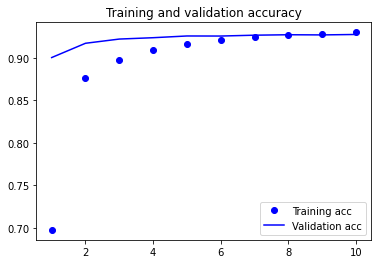

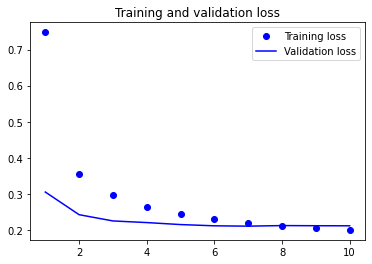

In [14]:
import matplotlib.pyplot as plt
#Plotting the model score and accuraccy for training and validation

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
txt = ["Regular fast food eating linked to fertility issues in women"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['entertainment', 'bussiness', 'science/tech', 'health']
print(pred, labels[np.argmax(pred)])

[[9.5046671e-05 8.2591485e-04 8.3585968e-05 9.9899548e-01]] health


In [24]:
#Saving the weights of the model

model.save_weights('./checkpoints/my_checkpoint')

In [28]:
#Saving the model

from keras.models import model_from_json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
